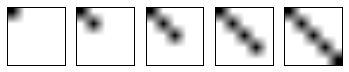

In [3]:
from numpy import zeros
from random import randint
from random import random
from matplotlib import pyplot
%matplotlib inline
# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
	# define the scope of the next step
	lower = max(0, last_step-1)
	upper = min(last_frame.shape[0]-1, last_step+1)
	# choose the row index for the next step
	step = randint(lower, upper)
	# copy the prior frame
	frame = last_frame.copy()
	# add the new step
	frame[step, column] = 1
	return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
	frames = list()
	# create the first frame
	frame = zeros((size,size))
	step = randint(0, size-1)
	# decide if we are heading left or right
	right = 1 if random() < 0.5 else 0
	col = 0 if right else size-1
	frame[step, col] = 1
	frames.append(frame)
	# create all remaining frames
	for i in range(1, size):
		col = i if right else size-1-i
		frame, step = next_frame(step, frame, col)
		frames.append(frame)
	return frames, right

# generate sequence of frames
size = 5
frames, right = build_frames(size)
# plot all feames
pyplot.figure()
for i in range(size):
	# create a grayscale subplot for each frame
	pyplot.subplot(1, size, i+1)
	pyplot.imshow(frames[i], cmap='Greys')
	# turn of the scale to make it cleaer
	ax = pyplot.gca()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
# show the plot
pyplot.show()

In [4]:
from random import random
from random import randint
from numpy import array
from numpy import zeros
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
	# define the scope of the next step
	lower = max(0, last_step-1)
	upper = min(last_frame.shape[0]-1, last_step+1)
	# choose the row index for the next step
	step = randint(lower, upper)
	# copy the prior frame
	frame = last_frame.copy()
	# add the new step
	frame[step, column] = 1
	return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
	frames = list()
	# create the first frame
	frame = zeros((size,size))
	step = randint(0, size-1)
	# decide if we are heading left or right
	right = 1 if random() < 0.5 else 0
	col = 0 if right else size-1
	frame[step, col] = 1
	frames.append(frame)
	# create all remaining frames
	for i in range(1, size):
		col = i if right else size-1-i
		frame, step = next_frame(step, frame, col)
		frames.append(frame)
	return frames, right

# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
	X, y = list(), list()
	for _ in range(n_patterns):
		frames, right = build_frames(size)
		X.append(frames)
		y.append(right)
	# resize as [samples, timesteps, width, height, channels]
	X = array(X).reshape(n_patterns, size, size, size, 1)
	y = array(y).reshape(n_patterns, 1)
	return X, y

# configure problem
size = 50

# define the model
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu'), input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

# fit model
X, y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs=1)

# evaluate model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print('loss: %f, acc: %f' % (loss, acc*100))

# prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
expected = "Right" if y[0]==1 else "Left"
predicted = "Right" if yhat[0]==1 else "Left"
print('Expected: %s, Predicted: %s' % (expected, predicted))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
5000/5000 [==============================] - 30s - loss: 0.1868 - acc: 0.9118    
loss: 0.003439, acc: 100.000000
Expecte